In [1]:
library(tidyverse)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [10]:
pre_cols <- c("nr", "RI")
stone_cols <- c("Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe")
post_cols <- c("Type")
all_cols <- c(pre_cols, stone_cols, post_cols)

df <- read_csv("glass.data", col_names = all_cols)
head(df)
dim(df)

Parsed with column specification:
cols(
  nr = col_integer(),
  RI = col_double(),
  Na = col_double(),
  Mg = col_double(),
  Al = col_double(),
  Si = col_double(),
  K = col_double(),
  Ca = col_double(),
  Ba = col_double(),
  Fe = col_double(),
  Type = col_integer()
)


nr,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0,0.00,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0,0.00,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0,0.00,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0,0.00,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0,0.00,1
6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0,0.26,1


[1] 214  11

In [20]:
long_stones <- df %>% select(stone_cols) %>% gather()
head(long_stones, 5)

key,value
Na,13.64
Na,13.89
Na,13.53
Na,13.21
Na,13.27


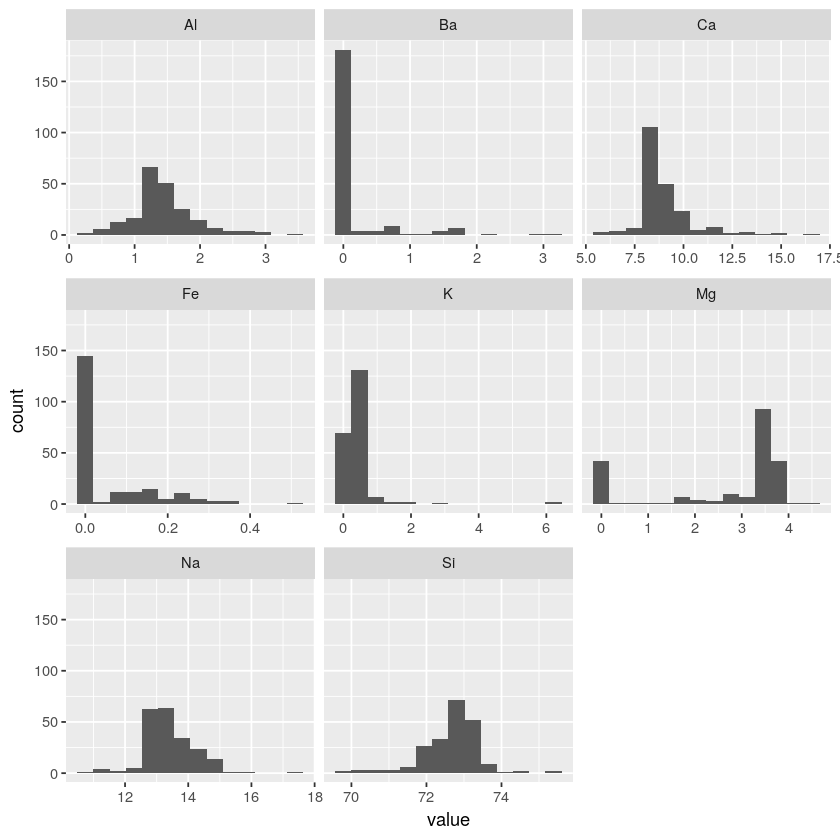

In [21]:
ggplot(long_stones, aes(value)) + geom_histogram(bins=14) + facet_wrap(~key, scales='free_x')